# 🧠 Behavior Drift Detector (Unsupervised ML Layer)

This notebook detects anomalous token usage patterns across API endpoints.
We use KMeans clustering to group similar behaviors and flag deviations.

## Inputs
- `api_access_logs.json` (user_id, token_id, timestamp, endpoint, status_code)

## Output
- Cluster labels
- `is_suspicious` flag for downstream defense systems
- Exported: `api_access_logs_labeled.csv`

This technique is useful for detecting lateral movement, token hijacking, and privilege escalation in AI-integrated infrastructure.


In [ ]:
import pandas as pd
import json

with open("../data/api_access_logs.json", "r") as f:
    logs = json.load(f)

df = pd.DataFrame(logs)
df.head()


In [16]:
from sklearn.preprocessing import LabelEncoder

# Make a copy of the original DataFrame
df_encoded = df.copy()

# Encode categorical fields
encoder = LabelEncoder()
df_encoded["user_id"] = encoder.fit_transform(df_encoded["user_id"])
df_encoded["token_id"] = encoder.fit_transform(df_encoded["token_id"])
df_encoded["endpoint"] = encoder.fit_transform(df_encoded["endpoint"])

# Drop timestamp for simplicity and select features
features = df_encoded[["user_id", "token_id", "endpoint", "status_code"]]


In [17]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
df["cluster"] = kmeans.fit_predict(features)


In [18]:
df.groupby("cluster").agg({
    "user_id": pd.Series.nunique,
    "token_id": pd.Series.nunique,
    "endpoint": pd.Series.nunique,
    "status_code": list
})

,user_id,token_id,endpoint,status_code
cluster,,,,
0,3,3,4,"[200, 200, 200, 200]"
1,1,1,1,[403]


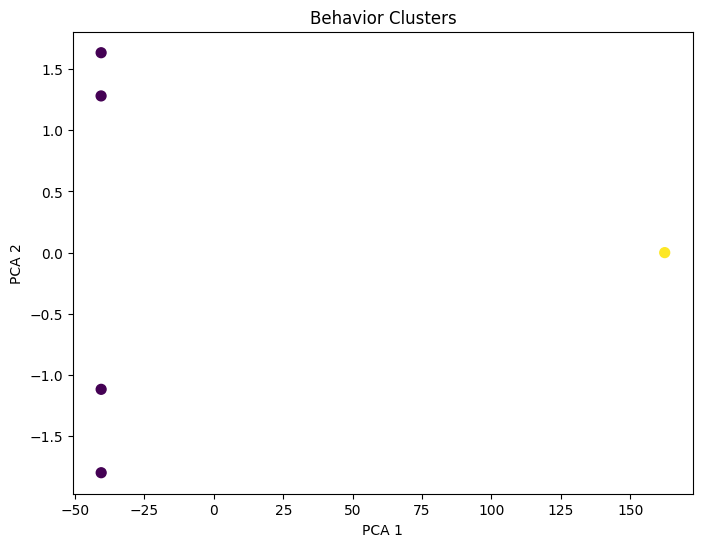

In [19]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce to 2D for plotting
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(features)

# Plot clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df["cluster"], cmap="viridis", s=50)
plt.title("Behavior Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


In [20]:
# Example: flag cluster 1 as suspicious
df["is_suspicious"] = (df["cluster"] == 1).astype(int)

In [21]:
df.to_csv("../data/api_access_logs_labeled.csv", index=False)